<a href="https://colab.research.google.com/github/wonee1/AI-puppysense/blob/main/PuppySense.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PuppySense

인공지능응용 프로젝트

모델학습 (colab 환경설정, 전이 학습 설정 진행)






## 1. Colab 환경설정 (GPU + 라이브러리 설치)

In [ ]:
!pip install tensorflow opencv-python matplotlib
!pip install efficientnet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.5 MB/s eta 0:00:00


# 2. 데이터 전처리하기

## 2.1 kaggle 데이터 다운하기

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
import kagglehub

# 1. kagglehub로 실제 경로 다운로드
path = kagglehub.dataset_download("danielshanbalico/dog-emotion")
data_dir = os.path.join(path, 'Dog Emotion')
print("실제 다운로드된 경로:", path)
print("해당 경로 내 파일/폴더:", os.listdir(path))




실제 다운로드된 경로: /kaggle/input/dog-emotion
해당 경로 내 파일/폴더: ['Dog Emotion']


## 2.2 데이터 로드


In [ ]:
# 2. labels.csv 경로
labels_csv_path = os.path.join(data_dir, 'labels.csv')
labels_df = pd.read_csv(labels_csv_path)

# 3. 감정 레이블 폴더 이름 불러오기
class_names = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
print(f'클래스 목록: {class_names}')

# 4. 레이블 매핑
label_map = {name: idx for idx, name in enumerate(class_names)}

# 5. 이미지 로딩 함수
def load_and_preprocess_img(img_path):
    img = cv2.imread(img_path)
    if img is None:
        print(f"이미지 파일을 불러올 수 없습니다: {img_path}")
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (112, 112))
    img = img / 255.0
    return img

# 6. 이미지 및 레이블 로딩
images, labels = [], []
for _, row in labels_df.iterrows():
    img_path = os.path.join(data_dir, row['label'], row['filename'])
    img = load_and_preprocess_img(img_path)
    if img is not None:
        images.append(img)
        labels.append(label_map[row['label']])

# 7. 배열 및 one-hot 인코딩
images = np.array(images)
labels = tf.keras.utils.to_categorical(labels, num_classes=len(class_names))

# 8. 확인
print(f'이미지 개수: {images.shape[0]}, 라벨 개수: {labels.shape[0]}')
print(f'라벨 예시 (one-hot):\n{labels[:5]}')

클래스 목록: ['angry', 'happy', 'relaxed', 'sad']
이미지 개수: 4000, 라벨 개수: 4000
라벨 예시 (one-hot):
[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]]


# 3. test, valid, train set 나누기

In [ ]:
from sklearn.model_selection import train_test_split

# 1) train+val / test 분리 (10%를 test로 분리)
train_val_images, test_images, train_val_labels, test_labels = train_test_split(
    images, labels, test_size=0.1, random_state=42, stratify=labels
)

# 2) train / val 분리 (train_val 중 10%를 validation으로 분리)
train_images, val_images, train_labels, val_labels = train_test_split(
    train_val_images, train_val_labels, test_size=0.1, random_state=42, stratify=train_val_labels
)


# 4. 전이 학습 모델 구성 (EfficientNetB0 사용)

## 4.1 Feature Extracter로 사전 학습

이미지넷으로 이미 학습된 가중치를 그대로 활용하기 위해서 Feature Extrator를 사용합니다. EfficientNetB0은 선, 모양 색 변화 등 저 수준의 특징을 추출하는 하위층과 귀,입, 꼬리 등 물체의 일부를 감지하는 중간 층, 그리고 전체 물체와 감정등을 추론하는 상위층으로 이루어져 있습니다.Feature Extractor에서 하위, 중간층만 그대로 받아옵니다.

In [ ]:
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2  # ✅ L2 정규화 임포트

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3)

base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(112, 112, 3))
base_model.trainable = False  # 처음엔 학습하지 않음 (Feature Extractor로 사용)

inputs = Input(shape=(112, 112, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.6)(x)

outputs = Dense(len(class_names), activation='softmax', kernel_regularizer=l2(0.0001))(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 1차 학습 (기본 모델 고정)
hist = model.fit(
    train_images, train_labels,
    epochs=15,
    validation_data=(val_images, val_labels),
    callbacks=[early_stop, reduce_lr]
)



Epoch 1/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 92s 440ms/step - accuracy: 0.2591 - loss: 1.5131 - val_accuracy: 0.2500 - val_loss: 1.4169 - learning_rate: 0.0010
Epoch 2/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - accuracy: 0.2565 - loss: 1.4742 - val_accuracy: 0.2417 - val_loss: 1.4042 - learning_rate: 0.0010
Epoch 3/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.2612 - loss: 1.4412 - val_accuracy: 0.2444 - val_loss: 1.3906 - learning_rate: 0.0010
Epoch 4/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.2636 - loss: 1.4520 - val_accuracy: 0.2639 - val_loss: 1.3884 - learning_rate: 0.0010
Epoch 5/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.2659 - loss: 1.4519 - val_accuracy: 0.2444 - val_loss: 1.3901 - learning_rate: 0.0010
Epoch 6/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.2634 - loss: 1.4367 - val_accuracy: 0.2917 - val_loss: 1.3974 - learning_rate: 0.0010
Epoch 7/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.2386 - loss:

## 4.2 상위층 학습

In [ ]:
# base_model의 일부 층부터 학습 가능하게 설정
base_model.trainable = True

# (선택) 특정 층까지만 학습되도록 설정하고 싶을 때:
# fine_tune_at = 100
# for layer in base_model.layers[:fine_tune_at]:
#     layer.trainable = False

# 컴파일 다시 (학습 가능한 가중치가 생겼기 때문)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # 전이학습엔 낮은 학습률이 중요
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 2차 학습 (전이 학습)
hist_fine = model.fit(
    train_images, train_labels,
    epochs=20,
    validation_data=(val_images, val_labels),
        callbacks=[early_stop, reduce_lr]
)


Epoch 1/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 264s 1s/step - accuracy: 0.2597 - loss: 1.5167 - val_accuracy: 0.2528 - val_loss: 1.4160 - learning_rate: 1.0000e-05
Epoch 2/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 28s 121ms/step - accuracy: 0.2818 - loss: 1.4740 - val_accuracy: 0.2472 - val_loss: 1.4143 - learning_rate: 1.0000e-05
Epoch 3/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 20s 120ms/step - accuracy: 0.3215 - loss: 1.4249 - val_accuracy: 0.2056 - val_loss: 1.4519 - learning_rate: 1.0000e-05
Epoch 4/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step - accuracy: 0.3435 - loss: 1.3703 - val_accuracy: 0.2667 - val_loss: 1.4043 - learning_rate: 1.0000e-05
Epoch 5/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 20s 120ms/step - accuracy: 0.3715 - loss: 1.3236 - val_accuracy: 0.3028 - val_loss: 1.3793 - learning_rate: 1.0000e-05
Epoch 6/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 21s 121ms/step - accuracy: 0.4173 - loss: 1.2830 - val_accuracy: 0.3722 - val_loss: 1.3023 - learning_rate: 1.0000e-05
Epoch 7/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 21s 122m

# 5. 데이터 증강학습

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,          # 회전
    width_shift_range=0.1,      # 가로 이동
    height_shift_range=0.1,     # 세로 이동
    shear_range=0.1,            # 전단
    zoom_range=0.2,             # 확대/축소
    horizontal_flip=True,       # 좌우 반전
    fill_mode='nearest'         # 빈 영역 보정 방식
)

train_generator = datagen.flow(train_images, train_labels, batch_size=8)

hist = model.fit(
    train_generator,
    epochs=15,
    validation_data=(val_images, val_labels),
    callbacks=[early_stop, reduce_lr],
    steps_per_epoch=len(train_images) // 8  # 증강은 batch 기반이라 꼭 필요함
)


Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


405/405 ━━━━━━━━━━━━━━━━━━━━ 138s 67ms/step - accuracy: 0.5546 - loss: 1.0532 - val_accuracy: 0.5500 - val_loss: 1.0240 - learning_rate: 1.0000e-05
Epoch 2/15
405/405 ━━━━━━━━━━━━━━━━━━━━ 68s 67ms/step - accuracy: 0.5496 - loss: 1.0459 - val_accuracy: 0.6056 - val_loss: 0.9809 - learning_rate: 1.0000e-05
Epoch 3/15
405/405 ━━━━━━━━━━━━━━━━━━━━ 41s 68ms/step - accuracy: 0.5659 - loss: 1.0212 - val_accuracy: 0.6333 - val_loss: 0.9307 - learning_rate: 1.0000e-05
Epoch 4/15
405/405 ━━━━━━━━━━━━━━━━━━━━ 29s 72ms/step - accuracy: 0.6061 - loss: 0.9547 - val_accuracy: 0.6194 - val_loss: 0.9487 - learning_rate: 1.0000e-05
Epoch 5/15
405/405 ━━━━━━━━━━━━━━━━━━━━ 39s 68ms/step - accuracy: 0.6025 - loss: 0.9618 - val_accuracy: 0.6222 - val_loss: 0.9245 - learning_rate: 1.0000e-05
Epoch 6/15
405/405 ━━━━━━━━━━━━━━━━━━━━ 27s 66ms/step - accuracy: 0.6201 - loss: 0.9188 - val_accuracy: 0.6639 - val_loss: 0.8857 - learning_rate: 1.0000e-05
Epoch 7/15
405/405 ━━━━━━━━━━━━━━━━━━━━ 41s 66ms/step - accura

# 6.테스트셋 평가

## 6.1 테스트셋 평가

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 685ms/step - accuracy: 0.7070 - loss: 0.7616
Test Accuracy: 0.7025, Test Loss: 0.7703


Keras 방식의 테스트 정확도 계산

In [ ]:
import time
from datetime import datetime

start_time = time.time()
start_dt = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"실행 시작: {start_dt}")

# 평가
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)
print(f"테스트 정확도: {test_acc:.4f}")

end_time = time.time()
end_dt = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"실행 종료: {end_dt}")
print(f"총 실행 시간: {end_time - start_time:.2f}초")




실행 시작: 2025-05-31 10:17:04
테스트 정확도: 0.5925
실행 종료: 2025-05-31 10:17:05
총 실행 시간: 0.84초


## 6.2 모델저장

자신의 드라이브에 저장되는 것이므로 파일 저장후 공용드라이브로 옮겨주어야 합니다.

In [ ]:
import os
import time
from datetime import datetime
from google.colab import drive

# Google Drive 마운트
drive.mount('/content/drive')

# 실행 시간 측정 시작
start_time = time.time()
start_dt = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"실행 시작: {start_dt}")

# 저장 디렉토리 설정
model_dir = "/content/drive/MyDrive/models"
os.makedirs(model_dir, exist_ok=True)

# 오늘 날짜를 파일 이름에 포함 (예: puppySenseModel_2025-05-23.keras)
today_str = datetime.now().strftime("%Y-%m-%d")
model_filename = f"puppySenseModel_{today_str}.keras"
model_path = os.path.join(model_dir, model_filename)

# 모델 저장 (TensorFlow/Keras)
model.save(model_path)
print(f"✅ 모델이 저장되었습니다: {model_path}")

# 실행 시간 측정 종료
end_time = time.time()
end_dt = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"실행 종료: {end_dt}")
print(f"총 실행 시간: {end_time - start_time:.2f}초")


Mounted at /content/drive
실행 시작: 2025-05-31 11:06:11
✅ 모델이 저장되었습니다: /content/drive/MyDrive/models/puppySenseModel_2025-05-31.keras
실행 종료: 2025-05-31 11:06:16
총 실행 시간: 4.83초


In [ ]:
#tensorFlow Model로 저장
model.save('saved_model/emotion_model')


ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=saved_model/emotion_model.

## 6.3 시각화

13/13 ━━━━━━━━━━━━━━━━━━━━ 23s 954ms/step


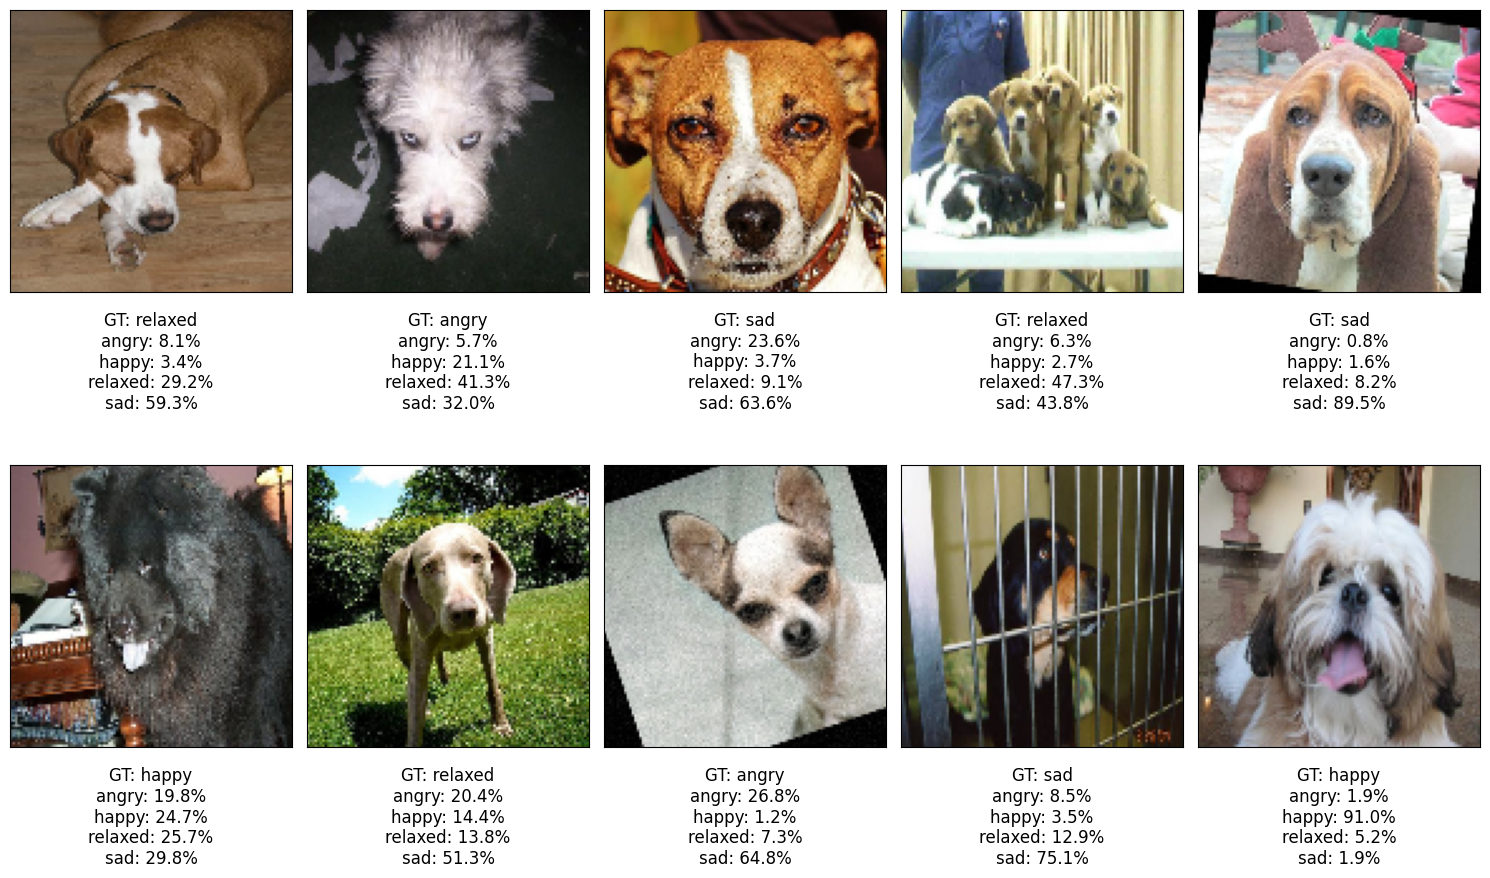

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 클래스 이름
class_names = ['angry', 'happy', 'relaxed', 'sad']

# 예측 확률
y_pred = model.predict(test_images)  # shape: (4000, 4)

# 예측 클래스 (argmax)
y_pred_class = np.argmax(y_pred, axis=1)
y_true_class = np.argmax(test_labels, axis=1)

# 이미지 10개 출력
fig = plt.figure(figsize=(15, 10))
for j in range(10):
    ax = fig.add_subplot(2, 5, j + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(test_images[j])  # 정규화된 이미지면 되돌리기

    true_label = class_names[y_true_class[j]]

    # 확률 리스트 문자열 생성
    prob_text = "\n".join([
        f"{class_names[i]}: {y_pred[j][i]*100:.1f}%" for i in range(len(class_names))
    ])

    # 텍스트 출력
    ax.text(
        0.5, -0.25,
        f"GT: {true_label}\n{prob_text}",
        size=12,
        ha='center',
        va='center',
        transform=ax.transAxes
    )

plt.tight_layout()
plt.show()


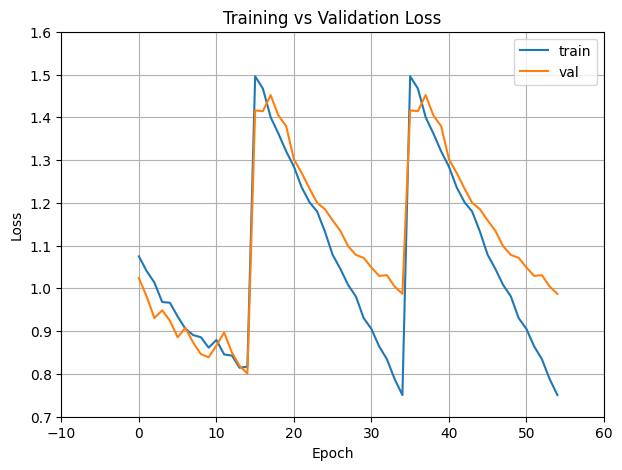

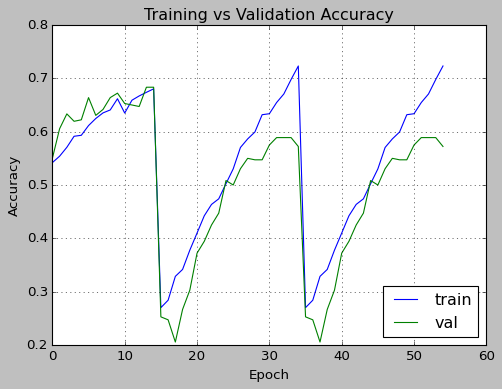

In [ ]:
# 두 히스토리 합치기 (간단히 리스트 이어붙이기)
for key in hist_fine.history.keys():
    hist.history[key].extend(hist_fine.history[key])

# 이제 hist.history에 10 epoch의 기록이 모두 들어있음

# 에포크 수 및 히스토리 정보
epochs = len(hist.history['loss'])  # epochs 수를 자동으로 가져옵니다
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
xc = range(epochs)

# 손실 그래프
plt.figure(1, figsize=(7, 5))
plt.plot(xc, train_loss, label='train')
plt.plot(xc, val_loss, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.grid(True)
plt.legend()
plt.style.use(['classic'])

# 정확도 그래프
plt.figure(2, figsize=(7, 5))
plt.plot(xc, train_acc, label='train')
plt.plot(xc, val_acc, label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.grid(True)
plt.legend(loc='lower right')
plt.style.use(['classic'])

plt.show()


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
              precision    recall  f1-score   support

       angry       0.73      0.51      0.60       100
       happy       0.56      0.62      0.59       100
     relaxed       0.56      0.62      0.59       100
         sad       0.69      0.74      0.71       100

    accuracy                           0.62       400
   macro avg       0.63      0.62      0.62       400
weighted avg       0.63      0.62      0.62       400



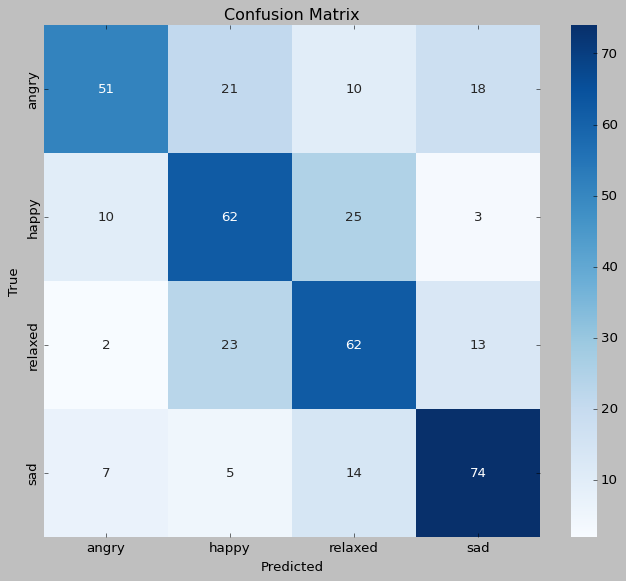

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_pred = model.predict(test_images)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(test_labels, axis=1)

print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))

# 혼동 행렬 시각화
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
